* Duplicating analysis in http://blog.yhat.com/posts/why-support-vector-machine.html
* Additionally checked comparison across grid search/accuracy metrics

In [2]:
import numpy as np
import pylab as pl
import pandas as pd
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Cows and Wolves

In [2]:
# open cows and wolves text
# add animal coordinates to df with animal type classifier as 0/1

data = open('cows_and_wolves.txt').read()
data = [item.split('\t') for item in data.strip().split('\n')]

In [3]:
animals = []

for i, row in enumerate(data):
    for j, item in enumerate(row):
        if item in ['o', 'x']:
            animals.append((i, j, item))

In [4]:
df = pd.DataFrame(animals, columns=['x', 'y', 'animal'])
df['animal_type'] = df.animal.apply(lambda x: 1 if x=='x' else 0)

In [5]:
df.head()

,x,y,animal,animal_type
0,0,0,o,0
1,0,2,o,0
2,0,4,o,0
3,1,1,o,0
4,1,4,x,1


In [6]:
# set train and test columns
# set classifier models to train on
# plot the prediction of all points based on these

train_cols = ['x', 'y']

clfs = {
    'svm': svm.SVC(),
    'decision tree': tree.DecisionTreeClassifier(),
    'logistic': linear_model.LogisticRegression(),
}

In [7]:
def plot_results_with_hyperplane(clf, clf_name, df, plt_nmbr):
    x_min, x_max = df.x.min() - .5, df.x.max() + .5
    y_min, y_max = df.y.min() - .5, df.y.max() + .5

    step = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    pl.subplot(2, 2, plt_nmbr)
    pl.pcolormesh(xx, yy, Z, cmap=pl.cm.Paired)

    for animal in df.animal.unique():
        pl.scatter(df[df.animal==animal].x,
                   df[df.animal==animal].y,
                   marker=animal,
                   label="cows" if animal=="x" else "wolves",
                   color='black')
    pl.title(clf_name)
    pl.legend(loc="best")


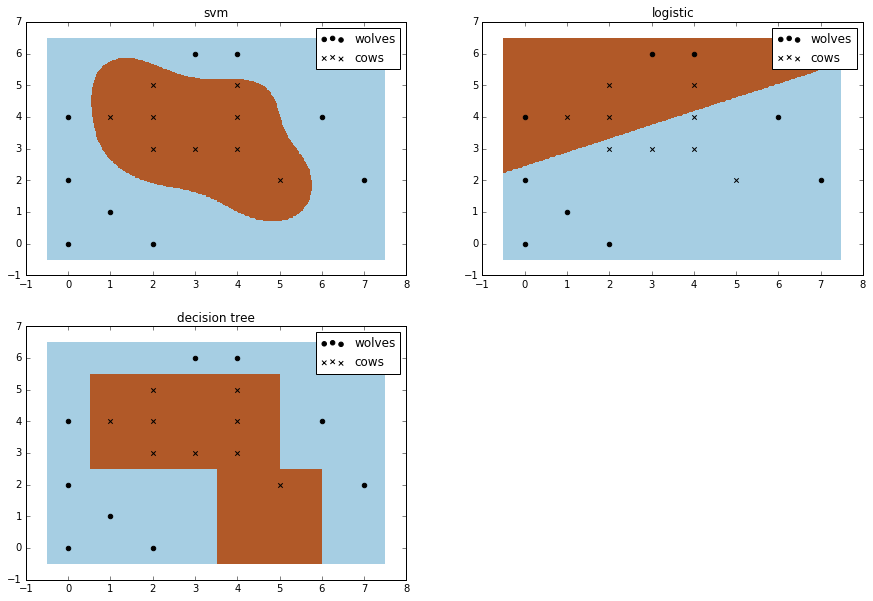

In [8]:
plt_nmbr = 1
for clf_name, clf in clfs.iteritems():
    clf.fit(df[train_cols], df.animal_type)
    plot_results_with_hyperplane(clf, clf_name, df, plt_nmbr)
    plt_nmbr += 1
pl.gcf().set_size_inches(15,10)
pl.show()

## Flag of Bangladesh

In [3]:
x_min, x_max = 0, 15
y_min, y_max = 0, 10
step = .1

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [4]:
df = pd.DataFrame(data={'x': xx.ravel(), 'y': yy.ravel()})

In [5]:
df['color_gauge'] = (df.x-7.5)**2 + (df.y-5)**2
df['color'] = df.color_gauge.apply(lambda x: 'red' if x <= 15 else 'green')
df['color_as_int'] = df.color.apply(lambda x: 0 if x=='red' else 1)

In [6]:
print "Points on flag"
print df.groupby('color').size()
print

Points on flag
color
green    10291
red       4709
dtype: int64



In [7]:
train_idx = df.x < 10

train = df[train_idx]
test = df[-train_idx]

In [8]:
print "Training data set: " + str(len(train))
print "Test data set: " + str(len(test))

Training data set: 10000
Test data set: 5000


In [8]:
cols = ['x', 'y']

In [9]:
clfs = {
    'svm': svm.SVC(degree=0.5),
    'logistic': linear_model.LogisticRegression(),
    'decision_tree': tree.DecisionTreeClassifier()
}

Confusion matrix for decision_tree:
[[1950 2458]
 [   0  592]]
Confusion matrix for svm:
[[4320   88]
 [  29  563]]
Confusion matrix for logistic:
[[   0 4408]
 [   0  592]]


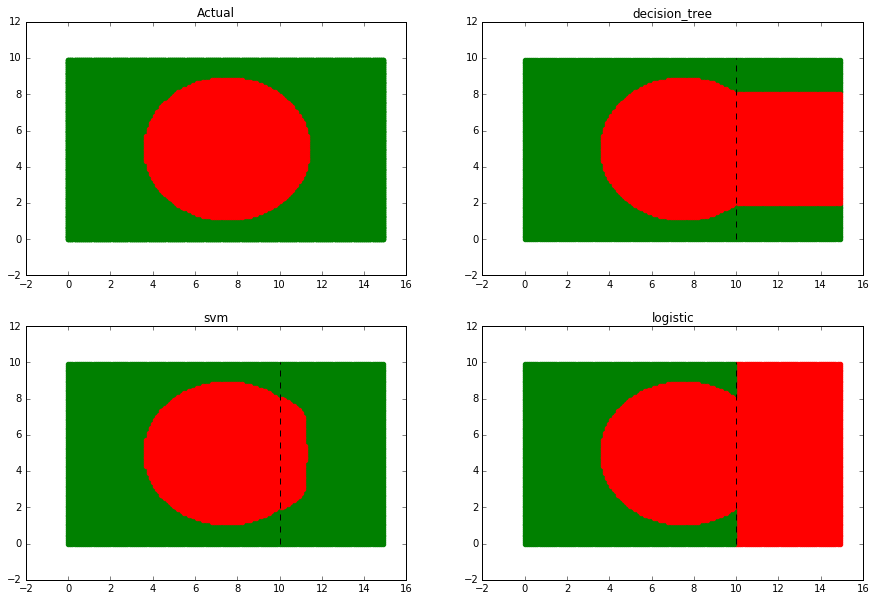

In [10]:
figure = 1

for clf_name, clf in clfs.items():

    for color in df.color.unique():
        idx = df.color==color
        pl.subplot(2, 2, 1)
        pl.scatter(df[idx].x, df[idx].y, color=color)
        pl.title('Actual')    

    figure += 1
    
    clf.fit(train[cols], train['color_as_int'])
    test['predicted_color_as_int'] = clf.predict(test[cols])
    test['predicted_color'] = test['predicted_color_as_int'].apply(lambda x: 'red' if x==0 else 'green')
    
    pl.subplot(2, 2, figure)

    for color in test.predicted_color.unique():
        idx = test.predicted_color==color
        pl.scatter(test[idx].x, test[idx].y, color=color)
    
    for color in train.color.unique():
        idx = train.color==color
        pl.scatter(train[idx].x, train[idx].y, color=color)
        
    train_line_y = np.linspace(0, 10)
    train_line_x = np.repeat(10, len(train_line_y))
    
    pl.plot(train_line_x, train_line_y, 'k--', color='black')
    
    pl.title(clf_name)
    
    print "Confusion matrix for %s:" % clf_name
    print confusion_matrix(test.color, test.predicted_color)

pl.gcf().set_size_inches(15,10)
pl.show()

### Tune Parameters for SVC

In [11]:
X_train, X_test, y_train, y_test = train[cols], test[cols], train['color_as_int'], test['color_as_int']

In [14]:
tuned_parameters = [
    {'kernel': ['rbf'], 'degree': [0.1, 0.5, 2, 3], 'C': [1, 10, 100, 1000]},
]

scores = ['precision', 'recall']

for score in scores:
    print ("# Tuning hyper-parameters for %s" % score)
    print ()
    
    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
        
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 100, 'degree': 0.1}
()
0.891 (+/-0.048) for {'kernel': 'rbf', 'C': 1, 'degree': 0.1}
0.891 (+/-0.048) for {'kernel': 'rbf', 'C': 1, 'degree': 0.5}
0.891 (+/-0.048) for {'kernel': 'rbf', 'C': 1, 'degree': 2}
0.891 (+/-0.048) for {'kernel': 'rbf', 'C': 1, 'degree': 3}
0.894 (+/-0.053) for {'kernel': 'rbf', 'C': 10, 'degree': 0.1}
0.894 (+/-0.053) for {'kernel': 'rbf', 'C': 10, 'degree': 0.5}
0.894 (+/-0.053) for {'kernel': 'rbf', 'C': 10, 'degree': 2}
0.894 (+/-0.053) for {'kernel': 'rbf', 'C': 10, 'degree': 3}
0.894 (+/-0.077) for {'kernel': 'rbf', 'C': 100, 'degree': 0.1}
0.894 (+/-0.077) for {'kernel': 'rbf', 'C': 100, 'degree': 0.5}
0.894 (+/-0.077) for {'kernel': 'rbf', 'C': 100, 'degree': 2}
0.894 (+/-0.077) for {'kernel': 'rbf', 'C': 100, 'degree': 3}
0.864 (+/-0.051) for {'kernel': 'rbf', 'C': 1000, 'degree': 0.1}
0.864 (+/-0.051) for {'kernel': 'rbf', 'C': 1000, 'de

In [16]:
clfs = {
    'svm-rbf-0.5': svm.SVC(degree=0.5),
    'svm-rbf-0.1-c10': svm.SVC(degree=0.1, C=10),
}

Confusion matrix for svm-rbf-0.1-c10:
[[4341   67]
 [  92  500]]
Confusion matrix for svm-rbf-0.5:
[[4320   88]
 [  29  563]]


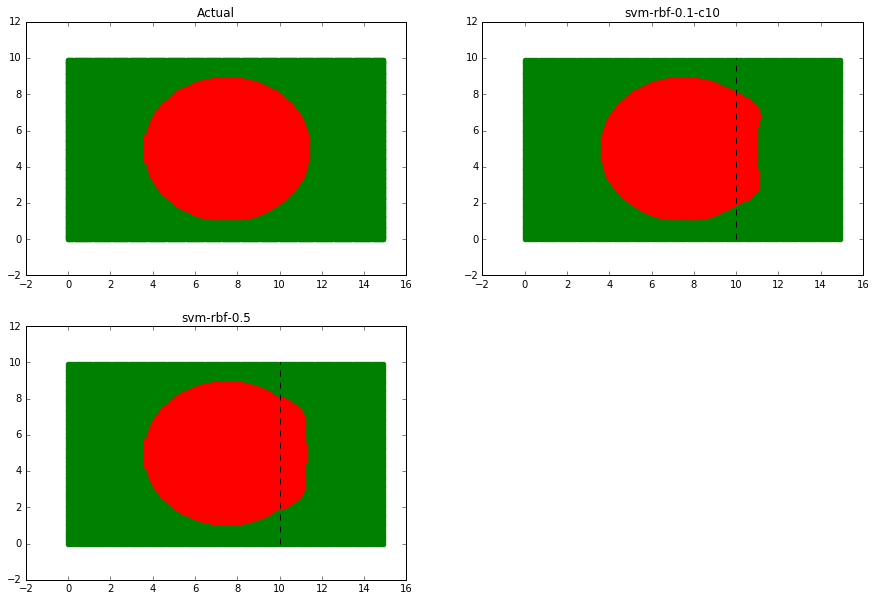

In [17]:
figure = 1

for clf_name, clf in clfs.items():

    for color in df.color.unique():
        idx = df.color==color
        pl.subplot(2, 2, 1)
        pl.scatter(df[idx].x, df[idx].y, color=color)
        pl.title('Actual')    

    figure += 1
    
    clf.fit(train[cols], train['color_as_int'])
    test['predicted_color_as_int'] = clf.predict(test[cols])
    test['predicted_color'] = test['predicted_color_as_int'].apply(lambda x: 'red' if x==0 else 'green')
    
    pl.subplot(2, 2, figure)

    for color in test.predicted_color.unique():
        idx = test.predicted_color==color
        pl.scatter(test[idx].x, test[idx].y, color=color)
    
    for color in train.color.unique():
        idx = train.color==color
        pl.scatter(train[idx].x, train[idx].y, color=color)
        
    train_line_y = np.linspace(0, 10)
    train_line_x = np.repeat(10, len(train_line_y))
    
    pl.plot(train_line_x, train_line_y, 'k--', color='black')
    
    pl.title(clf_name)
    
    print "Confusion matrix for %s:" % clf_name
    print confusion_matrix(test.color, test.predicted_color)

pl.gcf().set_size_inches(15,10)
pl.show()